In [ ]:
#Base Imports
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Pre Processing Imports
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#Model Building Imports
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from tensorflow.keras.optimizers import Adam , SGD ,RMSprop , Adagrad
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,Embedding, Dropout, GRU  
#Model Evaluation imports
from sklearn import metrics
from sklearn.metrics import (classification_report,confusion_matrix , 
                             precision_recall_curve ,precision_score,recall_score , accuracy_score,SCORERS)


 



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install scikeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('emotions_preprocessed.csv')

In [ ]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def remove_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def remove_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def clean(df):
    
    df.text=df.text.apply(lambda text : remove_stop_words(text))
    df.text=df.text.apply(lambda text : remove_numbers(text))
    df.text=df.text.apply(lambda text : remove_punctuations(text))
    df.text=df.text.apply(lambda text : remove_urls(text))
    df.text=df.text.apply(lambda text : lower_case(text))
    df.text=df.text.apply(lambda text : lemmatization(text))
    return df




  

In [ ]:
df = clean(df)
df

,text,labels
0,my favourite food anything i cook myself,1
1,now himself everyone think he laugh screwing p...,1
2,why the fuck is bayless isoing,12
3,to make feel threatened,7
4,dirty southern wanker,12
...,...,...
53989,it s pretty dangerous state decides fictional ...,7
53990,i filed divorce morning hoping move next day so,11
53991,the last time happened i said no closed door,13
53992,i can’t stand arrogant prick he’s better thenf...,12


In [ ]:
X= df.text 
y= df.labels
X_train, X_other, y_train, y_other = train_test_split(X, y, test_size=0.1, random_state=70)
X_val,X_test,y_val,y_test= train_test_split(X_other,y_other,test_size=0.5,random_state=70)
#90/5/5 split used


In [ ]:
X_train.head()

41908                               my new favorite phrase
37046    in comment accuses account fake prof identity ...
3620                      ah yes good old “glass elevator”
3504                      what hell poor name poor you wow
36509    yeah dare i want green arrow material green ar...
Name: text, dtype: object

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
# Tokenize words
tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train], axis=0))

In [ ]:
X_train

41908                               my new favorite phrase
37046    in comment accuses account fake prof identity ...
3620                      ah yes good old “glass elevator”
3504                      what hell poor name poor you wow
36509    yeah dare i want green arrow material green ar...
                               ...                        
21563    how supposed get link first place site trustwo...
25916                                         ooo i go far
44824              at job i can do get laid lot second one
21618                               what word i m confused
23886               honestly that’s wife material get that
Name: text, Length: 48594, dtype: object

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
max_len = max([len(t) for t in X_train])


In [ ]:
X_train = pad_sequences(sequences_train, maxlen=max_len, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=max_len, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=max_len, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 25336


## Text Representation Using Glove Embedding 

In [ ]:
#Text Representation Using Glove Embedding 
path_to_glove_file = 'glove.6B.300d.txt'
num_tokens = vocabSize
embedding_dim = 300
embeddings_index = {}
misses=0
hits=0


with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))



Found 12117 word vectors.
Converted 7264 words (18071 misses)


In [ ]:
X_train.shape

(48594, 531)

In [ ]:
y_train.shape

(48594, 14)

In [ ]:
# Define the function to create the model
def create_model(optimizer='adam'):
    gru_model = Sequential()
    gru_model.add(Embedding(vocabSize, 300, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
    gru_model.add(GRU(units=64, return_sequences=True))
    gru_model.add(Dropout(0.5))
    gru_model.add(GRU(units=32))
    gru_model.add(Dropout(0.5))
    gru_model.add(Dense(14, activation='softmax'))
    gru_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return gru_model
callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)
 
# Define the grid search parameter
param_grid = {
   'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.005), Adam(learning_rate=0.01),Adam(learning_rate=0.05),
                            SGD(learning_rate=0.001), SGD(learning_rate=0.005), SGD(learning_rate=0.01), SGD(learning_rate=0.05) ,
                            RMSprop(learning_rate=0.001), RMSprop(learning_rate=0.005), RMSprop(learning_rate=0.01), RMSprop(learning_rate=0.05),
                            Adagrad(learning_rate=0.001), Adagrad(learning_rate=0.005), Adagrad(learning_rate=0.01),Adagrad(learning_rate=0.05)],
}

## Hypertuned GRU Model Using Grid Search

In [ ]:
grid_model = KerasClassifier(model=create_model)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid ,cv=3)

# Fit the GridSearchCV object to the training data
grid_result = grid.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=15,
                    callbacks=[callback]
                   )

grid_training_time = sum(grid.cv_results_['mean_fit_time'])
print("Total training time For Grid Search: {:.2f} seconds".format(grid_training_time))

# Print the best parameters and the corresponding accuracy score
print("Best Parameters: ", grid_result.best_params_)
print("Best Accuracy: %.2f%%" % (grid_result.best_score_*100))

Epoch 1/15
127/127 [==============================] - 13s 63ms/step - loss: 2.2644 - accuracy: 0.3237 - val_loss: 1.9230 - val_accuracy: 0.4341
Epoch 2/15
127/127 [==============================] - 7s 59ms/step - loss: 1.9143 - accuracy: 0.4342 - val_loss: 1.7345 - val_accuracy: 0.4904
Epoch 3/15
127/127 [==============================] - 7s 59ms/step - loss: 1.8001 - accuracy: 0.4705 - val_loss: 1.6727 - val_accuracy: 0.4978
Epoch 4/15
127/127 [==============================] - 7s 58ms/step - loss: 1.7385 - accuracy: 0.4856 - val_loss: 1.6306 - val_accuracy: 0.5037
Epoch 5/15
127/127 [==============================] - 7s 58ms/step - loss: 1.6954 - accuracy: 0.4987 - val_loss: 1.5995 - val_accuracy: 0.5200
Epoch 6/15
127/127 [==============================] - 7s 58ms/step - loss: 1.6614 - accuracy: 0.5073 - val_loss: 1.5744 - val_accuracy: 0.5230
Epoch 7/15
127/127 [==============================] - 7s 57ms/step - loss: 1.6354 - accuracy: 0.5131 - val_loss: 1.5598 - val_accuracy: 0.523

In [ ]:
grid_y_pred = grid.predict(X_test)
grid_y_pred_labels = np.argmax(grid_y_pred, axis=1)
grid_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(grid_y_test_labels, grid_y_pred_labels))

85/85 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.50      0.80      0.62       763
           1       0.42      0.31      0.36       195
           2       0.51      0.39      0.44        90
           3       0.46      0.34      0.39        53
           4       0.59      0.06      0.11       168
           5       0.63      0.62      0.63       278
           6       0.58      0.56      0.57        52
           7       0.84      0.81      0.83       134
           8       0.69      0.71      0.70       206
           9       0.44      0.30      0.36        91
          10       0.58      0.41      0.48       144
          11       0.52      0.45      0.48       252
          12       0.33      0.10      0.15       136
          13       0.52      0.52      0.52       138

    accuracy                           0.55      2700
   macro avg       0.54      0.46      0.47      2700
weighted avg       0.54   

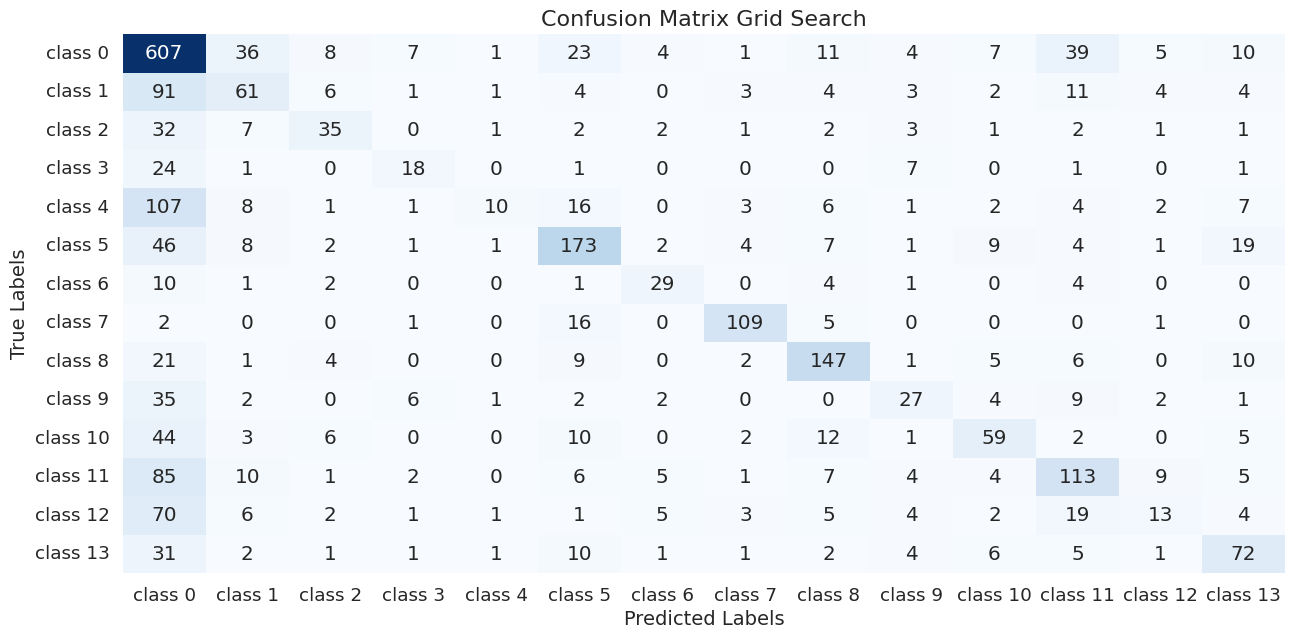

In [ ]:
conf_mat_grid= confusion_matrix(grid_y_test_labels, grid_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_grid, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix Grid Search', fontsize=16)
plt.show()

## Hypertuned GRU Model Using Random Search

In [ ]:
# Create the KerasClassifier object
rand_model = KerasClassifier(model=create_model)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=rand_model, param_distributions=param_grid, cv=3)

# Fit the RandomizedSearchCV object to the training data
random_result = random_search.fit(X_train,
                                  y_train,
                                  validation_data=(X_val, y_val),
                                  verbose=1,
                                  batch_size=256,
                                  epochs=15,
                                  callbacks=[callback]
                                 )
rand_training_time = sum(random_search.cv_results_['mean_fit_time'])
print("Total training time For Random Search: {:.2f} seconds".format(rand_training_time))
# Print the best parameters and the corresponding accuracy score
print("Best Parameters: ", random_result.best_params_)
print("Best Accuracy: %.2f%%" % (random_result.best_score_*100))


Epoch 1/15
127/127 [==============================] - 18s 63ms/step - loss: 2.2919 - accuracy: 0.3222 - val_loss: 2.0265 - val_accuracy: 0.3974
Epoch 2/15
127/127 [==============================] - 7s 55ms/step - loss: 2.0302 - accuracy: 0.4017 - val_loss: 1.9015 - val_accuracy: 0.4341
Epoch 3/15
127/127 [==============================] - 7s 56ms/step - loss: 1.9337 - accuracy: 0.4310 - val_loss: 1.8379 - val_accuracy: 0.4507
Epoch 4/15
127/127 [==============================] - 7s 57ms/step - loss: 1.8798 - accuracy: 0.4453 - val_loss: 1.7963 - val_accuracy: 0.4633
Epoch 5/15
127/127 [==============================] - 8s 66ms/step - loss: 1.8433 - accuracy: 0.4571 - val_loss: 1.7736 - val_accuracy: 0.4678
Epoch 6/15
127/127 [==============================] - 7s 58ms/step - loss: 1.8166 - accuracy: 0.4624 - val_loss: 1.7419 - val_accuracy: 0.4744
Epoch 7/15
127/127 [==============================] - 7s 57ms/step - loss: 1.7884 - accuracy: 0.4683 - val_loss: 1.7270 - val_accuracy: 0.474

In [ ]:
rand_y_pred = random_search.predict(X_test)
rand_y_pred_labels = np.argmax(rand_y_pred, axis=1)
rand_y_test_labels = np.argmax(y_test, axis=1)
print(classification_report(rand_y_test_labels, rand_y_pred_labels))

85/85 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

           0       0.43      0.83      0.57       763
           1       0.42      0.30      0.35       195
           2       0.53      0.22      0.31        90
           3       0.47      0.28      0.35        53
           4       0.54      0.11      0.19       168
           5       0.58      0.55      0.57       278
           6       0.61      0.42      0.50        52
           7       0.80      0.84      0.82       134
           8       0.57      0.32      0.41       206
           9       0.34      0.23      0.27        91
          10       0.56      0.42      0.48       144
          11       0.45      0.18      0.25       252
          12       0.33      0.04      0.07       136
          13       0.48      0.51      0.49       138

    accuracy                           0.48      2700
   macro avg       0.51      0.38      0.40      2700
weighted avg       0.49   

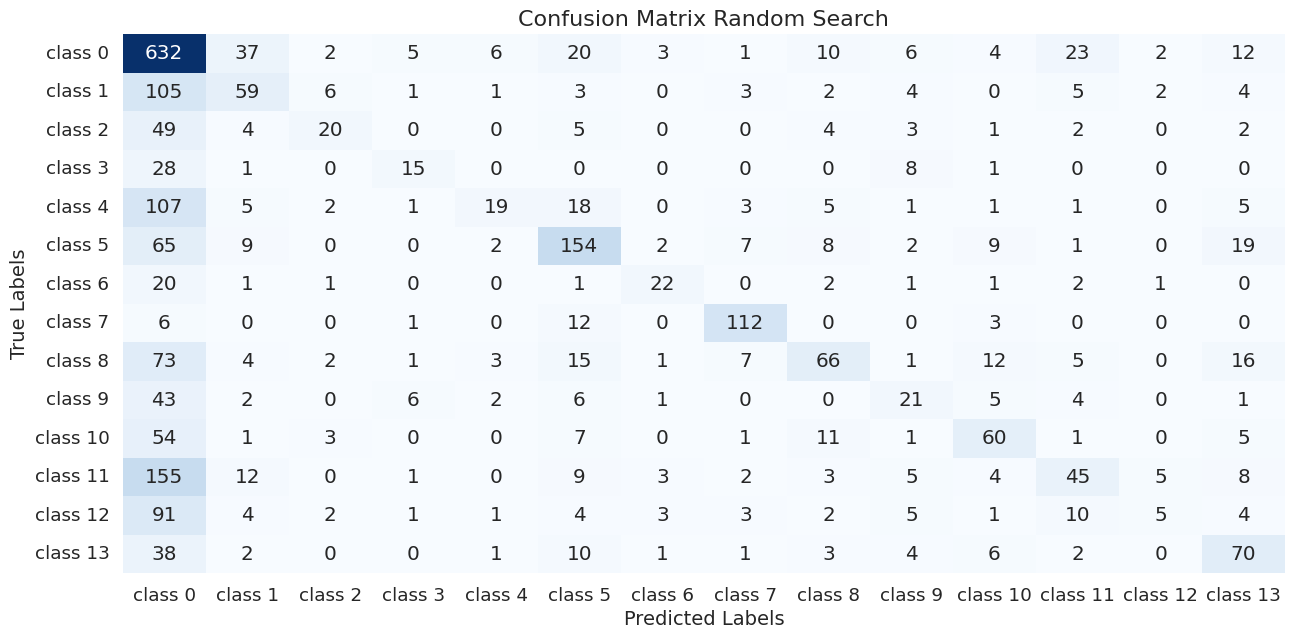

In [ ]:
conf_mat_rand= confusion_matrix(rand_y_test_labels, rand_y_pred_labels)
plt.figure(figsize=(15,7))
# create a heatmap of the confusion matrix
sns.set(font_scale=1.2)
sns.heatmap(conf_mat_rand, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'],
            yticklabels=['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5',
                         'class 6', 'class 7', 'class 8', 'class 9', 'class 10',
                         'class 11', 'class 12', 'class 13'])
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.title('Confusion Matrix Random Search', fontsize=16)
plt.show()